### Image completion? 

Notes: 
- Uses plain SGD so training is rediculously slow. I implemented this quickly so I did not bother using VMAP to run the data in batches.


In [1]:
import numpy as np
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as py
from jax import grad,jit

### Generating Data: The data is basically a array ranged from 0:1600 reshaped into a 40x40 image. 

In [2]:

image=np.array(range(40*40)) #This is the underlying image.
image=image/(40*40) #normalized between 0 and 1
image=image.reshape(40,40)


data=[]

for i in range(100): 
  temp=np.ones((40,40))
  rx=np.random.randint(0,30) 
  ry=np.random.randint(0,30)
  temp[rx:rx+10,ry:ry+10]=0 #Here I am removing squares of the image at random spots. 
  data.append(image*temp)

### This is an example of the data, change the indice 

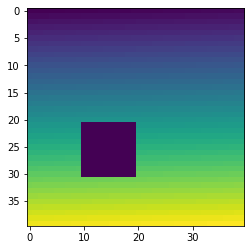

In [3]:
py.imshow(data[0])

### Underlying Image.

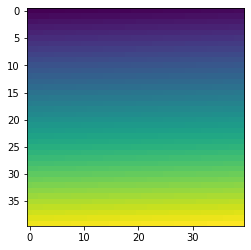

In [4]:
py.imshow(image)

### The main functions for the network 
- The shapes of the matrices are not quite what I saw on the paper. 

In [5]:
# This is the neural network . Input here is 'Z', the network parameters here are P , and the output layer 1 be 'X' the compelted matrix.
#shape (X) = [40,40]
# shape(Z) = [1,100]
# shape(P) = [40*40,100]
#the network is doing, X~=Z*P

def forward(input,params): 
  layer1=jnp.dot(input,params[0].T) +params[1] 
  layer1=jax.nn.sigmoid(layer1)
  return layer1 #image


#This is just the MSE 
def MSE(pred,image): 
  diff=(pred-image)**2
  sum=jnp.sum(diff)
  return sum/(40*40)

#This is to allow Jax to calculate the gradient. 
def backwards(input,params,image): 
  pred=forward(input,params) 
  return MSE(pred,image) #+ (0.2*abs(np.sum(params)))

#This is probably the most different this line below is saying to calculate gradient w.r.t to the input, which is Z, and params which is 'P'. normally you would specify gradient w.r.t to parameters only. 

gradient=grad(backwards,argnums=(0,1)) 

### Randomize Parameters

In [6]:
np.random.seed(1001)

#randomize Z - This will be the input to the network.
z=np.random.randn(100)

#parameters: 
param=[]
param.append(np.random.randn(40*40,100)/10) 
param.append(np.random.randn(40*40)) 


### Training Loop - Using good old fashion SGD, but you can implement RMSProp etc . 

In [7]:
lr=0.1 #this is finicky since I am using np.random.randn to initialize parameters and not some other initialization/scaling scheme.
plotting=[]
epochs=50
for e in range(epochs) :
  loss=0.0  
  for sam in (data):
    sam=sam.flatten() 
    #calculates gradient, w.r.t to 'Z' and params (which is like calculating gradient w.r.t to Z and P 
    dz,dp=jit(gradient)(z,param,sam)  
    loss+=backwards(z,param,sam)
    #Update parameters 
    z=z-(lr*dz) 
    param[0]-=lr*dp[0]
    param[1]-=lr*dp[1]
    

  print(f'epoch: ', e,' loss : ', loss/100) 
  plotting.append(loss) 


epoch:  0  loss :  0.15058295
epoch:  1  loss :  0.14149667
epoch:  2  loss :  0.13285619
epoch:  3  loss :  0.1246578
epoch:  4  loss :  0.11689529
epoch:  5  loss :  0.10956112
epoch:  6  loss :  0.10264695
epoch:  7  loss :  0.09614445
epoch:  8  loss :  0.090044774
epoch:  9  loss :  0.0843385
epoch:  10  loss :  0.079015255
epoch:  11  loss :  0.07406341
epoch:  12  loss :  0.06947013
epoch:  13  loss :  0.06522168
epoch:  14  loss :  0.061303787
epoch:  15  loss :  0.05770168
epoch:  16  loss :  0.054399755
epoch:  17  loss :  0.051381037
epoch:  18  loss :  0.048626978
epoch:  19  loss :  0.0461173
epoch:  20  loss :  0.04383067
epoch:  21  loss :  0.041745655
epoch:  22  loss :  0.03984174
epoch:  23  loss :  0.038100123
epoch:  24  loss :  0.03650425
epoch:  25  loss :  0.035039857
epoch:  26  loss :  0.033694666
epoch:  27  loss :  0.03245791
epoch:  28  loss :  0.031320017
epoch:  29  loss :  0.030272394
epoch:  30  loss :  0.029307429
epoch:  31  loss :  0.028418431
epoch: 

### Plot training : loss versus epochs. 
- No axes labels-Nice

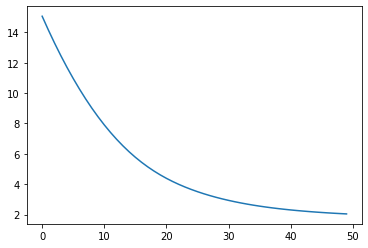

In [8]:
py.plot(range(0,epochs),plotting)

### See what the network outputs, but using the learned 'Z' and 'Param' values.

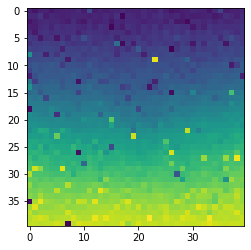

In [9]:
t=forward(z,param)
py.imshow(t.reshape(40,40))